In [54]:
# imports
import os
import numpy as np
import pandas as pd
from IPython.display import Image
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, MaxPool2D, Conv2D, Flatten, Dropout, BatchNormalization
from keras import regularizers
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from PIL import Image as img


In [2]:
np.random.seed(100)

In [3]:
print(os.listdir('input'))

['sample_submission.csv', 'test', 'train', 'train.csv']


In [4]:
data_dir = "input"
train_dir = data_dir + "/train/"
test_dir = data_dir + "/test/"
train_f_url = data_dir + "/train.csv"
test_f_url = data_dir + "/sample_submission.csv"
train_df = pd.read_csv(train_f_url)
test_df = pd.read_csv(test_f_url)

In [5]:
t_img_size = 200
Image(data=train_dir+train_df.iloc[0, 0], width=t_img_size, height=t_img_size)
print("Classification: 1 if has cactus 0 if no cactus : Value: {0}".format(train_df.iloc[0, 1]))

Classification: 1 if has cactus 0 if no cactus : Value: 1


In [6]:
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [7]:
train_df['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

In [8]:
print("Test rows {0} and columns {1}".format(test_df.shape[0], test_df.shape[1]))

Test rows 4000 and columns 2


In [9]:
print("Train rows {0} and columns {1}".format(train_df.shape[0], train_df.shape[1]))

Train rows 17500 and columns 2


In [10]:
cacti = train_df[train_df.has_cactus==1].sample(n=3, random_state=42)
not_cacti = train_df[train_df.has_cactus==0].sample(n=3, random_state=50)

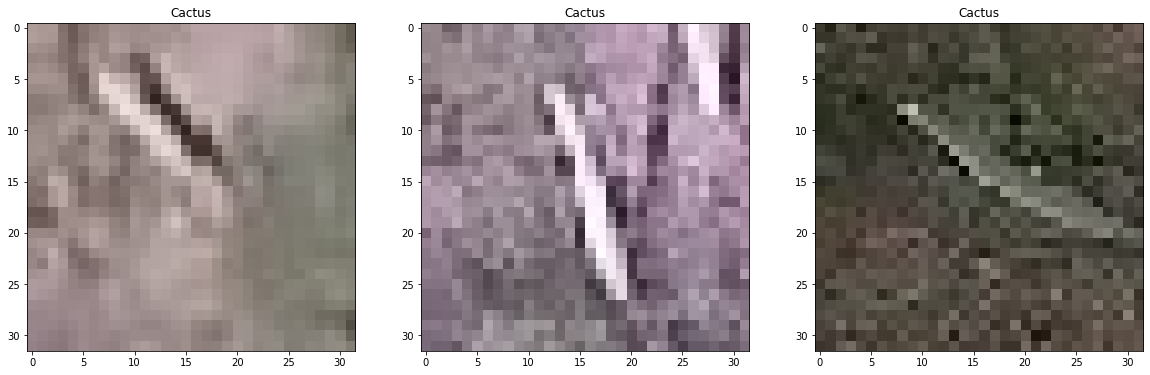

In [11]:
from PIL import Image
fig = plt.figure(1, figsize=(20, 20))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    pil_im = Image.open(train_dir + cacti.iloc[i, 0])
    im_arry = np.asarray(pil_im)
    arr = im_arry
    plt.title('Cactus')
    ax.imshow(arr)
plt.show()

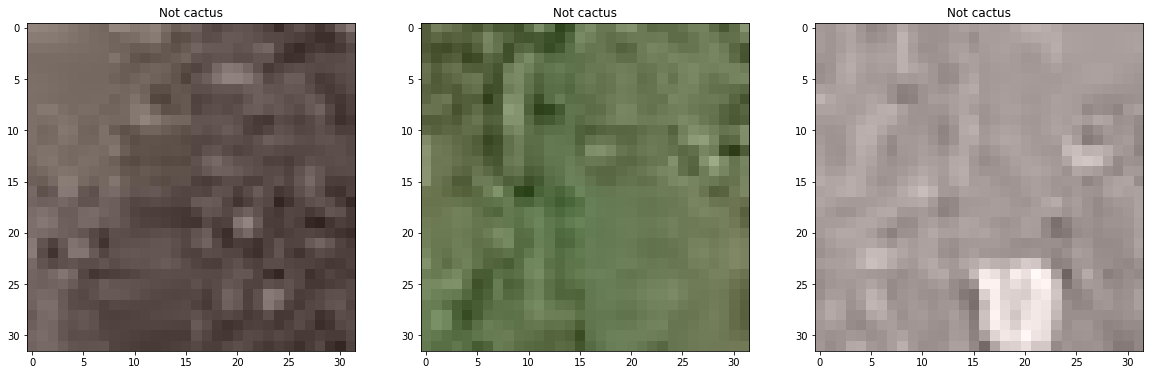

In [12]:
fig = plt.figure(1, figsize=(20, 20))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    pil_im = Image.open(train_dir + not_cacti.iloc[i, 0])
    im_arry = np.asarray(pil_im)
    arr = im_arry
    plt.title('Not cactus')
    ax.imshow(arr, cmap='viridis')
plt.show()

In [13]:
train_df.has_cactus = train_df.has_cactus.astype(str)


In [14]:
def benchmark_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D(2, 2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model


In [15]:
model = benchmark_model()
model.summary()

W0714 17:25:06.703543 15988 deprecation_wrapper.py:119] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 17:25:06.723531 15988 deprecation_wrapper.py:119] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 17:25:06.725530 15988 deprecation_wrapper.py:119] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0714 17:25:06.743525 15988 deprecation_wrapper.py:119] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
__________

In [16]:
def plot_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [17]:
def get_train_val_rows(train_df):
    len_train = len(train_df.index)
    ind = int(0.70*len_train)
    train_rows = train_df[:ind].shape[0] // 100
    val_rows = train_df[ind:].shape[0] // 50
    return train_rows, val_rows


In [18]:
def get_train_valid_generators_with_scale(train_df, target_size=32, train_batch_size=100, val_batch_size=50):
    train_df = shuffle(train_df)
    gen = ImageDataGenerator(rescale=1./255)
    len_train = len(train_df.index)
    ind = int(0.70*len_train)
    train_gen = gen.flow_from_dataframe(dataframe=train_df[:ind],directory=train_dir,x_col='id',
                                                y_col='has_cactus',class_mode='binary',batch_size=train_batch_size,
                                                target_size=(target_size,target_size))


    val_gen = gen.flow_from_dataframe(dataframe=train_df[ind:],directory=train_dir,x_col='id',
                                                    y_col='has_cactus',class_mode='binary',batch_size=val_batch_size,
                                                    target_size=(target_size,target_size))
    return train_gen, val_gen, ind


In [19]:
train_rows, val_rows = get_train_val_rows(train_df)

In [20]:
train_gen, val_gen, ind = get_train_valid_generators_with_scale(train_df)

Found 12250 validated image filenames belonging to 2 classes.
Found 5250 validated image filenames belonging to 2 classes.


In [21]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(train_gen.classes), train_gen.classes)

In [22]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit_generator(train_gen, epochs=10, steps_per_epoch=train_rows, validation_data=val_gen, validation_steps=val_rows, class_weight=class_weights)

W0714 17:25:08.731192 15988 deprecation_wrapper.py:119] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0714 17:25:08.752191 15988 deprecation_wrapper.py:119] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\site-packages\keras\backend\tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0714 17:25:08.758188 15988 deprecation.py:323] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0714 17:25:08.996177 15988 deprecation_wrapper.p

Epoch 1/10
122/122 [==============================] - 9s 70ms/step - loss: 0.2568 - acc: 0.8849 - val_loss: 0.1379 - val_acc: 0.9490
Epoch 2/10
122/122 [==============================] - 8s 67ms/step - loss: 0.1377 - acc: 0.9495 - val_loss: 0.1144 - val_acc: 0.9577
Epoch 3/10
122/122 [==============================] - 8s 66ms/step - loss: 0.1017 - acc: 0.9625 - val_loss: 0.0923 - val_acc: 0.9670
Epoch 4/10
122/122 [==============================] - 8s 66ms/step - loss: 0.0828 - acc: 0.9702 - val_loss: 0.0696 - val_acc: 0.9752
Epoch 5/10
122/122 [==============================] - 8s 64ms/step - loss: 0.0774 - acc: 0.9712 - val_loss: 0.0840 - val_acc: 0.9672
Epoch 6/10
122/122 [==============================] - 8s 64ms/step - loss: 0.0660 - acc: 0.9757 - val_loss: 0.0566 - val_acc: 0.9808
Epoch 7/10
122/122 [==============================] - 8s 66ms/step - loss: 0.0730 - acc: 0.9734 - val_loss: 0.0681 - val_acc: 0.9760
Epoch 8/10
122/122 [==============================] - 9s 76ms/step - 

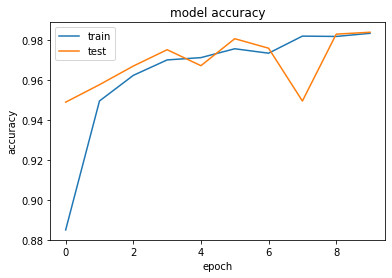

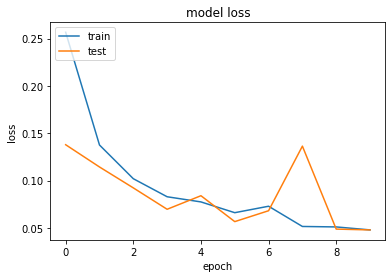

In [23]:
plot_history(history)

In [24]:
# Benchmark model has training acc greater than test accuracy -> could mean overfitting, solution: dropout
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.1))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPool2D(2, 2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

W0714 17:26:34.506737 15988 deprecation.py:506] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 64)          18496     
__________

In [25]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit_generator(train_gen, epochs=10, class_weight=class_weights, steps_per_epoch=train_rows, validation_data=val_gen, validation_steps=val_rows)

Epoch 1/10
122/122 [==============================] - 10s 85ms/step - loss: 0.2850 - acc: 0.8684 - val_loss: 0.1409 - val_acc: 0.9495
Epoch 2/10
122/122 [==============================] - 9s 78ms/step - loss: 0.1429 - acc: 0.9459 - val_loss: 0.1143 - val_acc: 0.9602
Epoch 3/10
122/122 [==============================] - 10s 81ms/step - loss: 0.1110 - acc: 0.9582 - val_loss: 0.0933 - val_acc: 0.9695
Epoch 4/10
122/122 [==============================] - 9s 73ms/step - loss: 0.1044 - acc: 0.9610 - val_loss: 0.0955 - val_acc: 0.9705
Epoch 5/10
122/122 [==============================] - 9s 73ms/step - loss: 0.0894 - acc: 0.9677 - val_loss: 0.0823 - val_acc: 0.9716
Epoch 6/10
122/122 [==============================] - 9s 76ms/step - loss: 0.0846 - acc: 0.9689 - val_loss: 0.0697 - val_acc: 0.9779
Epoch 7/10
122/122 [==============================] - 9s 73ms/step - loss: 0.0719 - acc: 0.9750 - val_loss: 0.0577 - val_acc: 0.9808
Epoch 8/10
122/122 [==============================] - 9s 72ms/step 

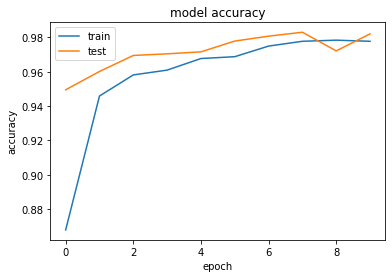

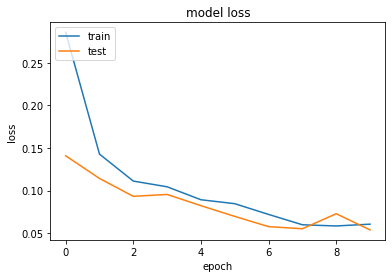

In [26]:
plot_history(history)

In [27]:
aug_train_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, rescale=1./255)
atrain_gen = aug_train_gen.flow_from_dataframe(dataframe=train_df[:ind],directory=train_dir,x_col='id',
                                            y_col='has_cactus',class_mode='binary',batch_size=100,
                                            target_size=(32,32))


Found 12250 validated image filenames belonging to 2 classes.


In [28]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(atrain_gen.classes), atrain_gen.classes)

In [29]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit_generator(atrain_gen, epochs=10, steps_per_epoch=train_rows, validation_data=val_gen, validation_steps=val_rows, class_weight=class_weights)

Epoch 1/10
122/122 [==============================] - 17s 140ms/step - loss: 0.1018 - acc: 0.9620 - val_loss: 0.0790 - val_acc: 0.9691
Epoch 2/10
122/122 [==============================] - 16s 127ms/step - loss: 0.0919 - acc: 0.9648 - val_loss: 0.1135 - val_acc: 0.9556
Epoch 3/10
122/122 [==============================] - 18s 148ms/step - loss: 0.0890 - acc: 0.9666 - val_loss: 0.0572 - val_acc: 0.9790
Epoch 4/10
122/122 [==============================] - 17s 136ms/step - loss: 0.0750 - acc: 0.9719 - val_loss: 0.0919 - val_acc: 0.9629
Epoch 5/10
122/122 [==============================] - 15s 124ms/step - loss: 0.0739 - acc: 0.9725 - val_loss: 0.0418 - val_acc: 0.9855
Epoch 6/10
122/122 [==============================] - 16s 130ms/step - loss: 0.0842 - acc: 0.9670 - val_loss: 0.0547 - val_acc: 0.9790
Epoch 7/10
122/122 [==============================] - 18s 150ms/step - loss: 0.0708 - acc: 0.9743 - val_loss: 0.0606 - val_acc: 0.9754
Epoch 8/10
122/122 [==============================] - 1

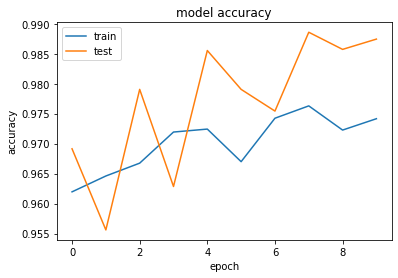

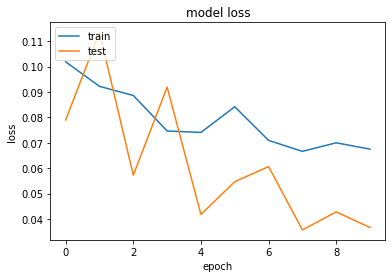

In [30]:
plot_history(history)

In [31]:
x_test = []
ids = []
for f in os.listdir(test_dir):
    ids.append(f)
    path = os.path.join(test_dir, f)
    pil_arr = np.asarray(img.open(path))
    x_test.append(pil_arr)
x_test = np.array(x_test)
print(x_test.shape)
x_test = x_test.astype('float32')/255

(3975, 32, 32, 3)


In [32]:
predictions = model.predict_proba(x_test)

In [33]:
test_df = pd.DataFrame({'id': ids, 'has_cactus': predictions.flatten()})

In [34]:
test_df.to_csv("samplesubmission.csv", index=False)

In [35]:
from keras.applications.vgg16 import VGG16

In [36]:
vgg16 = VGG16(weights = 'imagenet', input_shape = (32, 32, 3), include_top = False)
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [37]:
for layer in vgg16.layers:
    layer.trainable = False

In [63]:
vgg_model = Sequential()
vgg_model.add(vgg16)
vgg_model.add(Flatten())
vgg_model.add(Dense(500, activation = 'relu'))
vgg_model.add(BatchNormalization())
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(300, activation = 'relu'))
vgg_model.add(BatchNormalization())
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(100, activation = 'relu'))
vgg_model.add(BatchNormalization())
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(1, activation = 'sigmoid'))

vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_11 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 500)               256500    
_________________________________________________________________
batch_normalization_10 (Batc (None, 500)               2000      
_________________________________________________________________
dropout_14 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 300)               150300    
_________________________________________________________________
batch_normalization_11 (Batc (None, 300)               1200      
__________

In [65]:
vgg_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [66]:
vgg_history = vgg_model.fit_generator(train_gen, epochs=50, shuffle=True, steps_per_epoch=train_rows, validation_data=val_gen, validation_steps=val_rows, class_weight=class_weights)

Epoch 1/50
122/122 [==============================] - 70s 577ms/step - loss: 0.2827 - acc: 0.8956 - val_loss: 0.1743 - val_acc: 0.9318
Epoch 2/50
122/122 [==============================] - 71s 582ms/step - loss: 0.1538 - acc: 0.9493 - val_loss: 0.2154 - val_acc: 0.9095
Epoch 3/50
122/122 [==============================] - 63s 518ms/step - loss: 0.1268 - acc: 0.9566 - val_loss: 0.1894 - val_acc: 0.9223
Epoch 4/50
122/122 [==============================] - 64s 523ms/step - loss: 0.1167 - acc: 0.9590 - val_loss: 0.1121 - val_acc: 0.9535
Epoch 5/50
122/122 [==============================] - 64s 528ms/step - loss: 0.1070 - acc: 0.9625 - val_loss: 0.3105 - val_acc: 0.8821
Epoch 6/50
122/122 [==============================] - 64s 526ms/step - loss: 0.1022 - acc: 0.9642 - val_loss: 0.1634 - val_acc: 0.9309
Epoch 7/50
122/122 [==============================] - 64s 525ms/step - loss: 0.0976 - acc: 0.9629 - val_loss: 0.2149 - val_acc: 0.9097
Epoch 8/50
122/122 [==============================] - 6

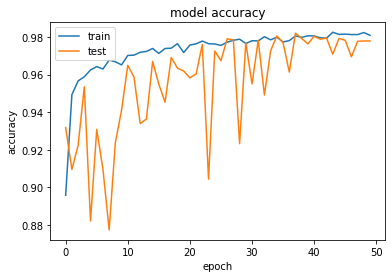

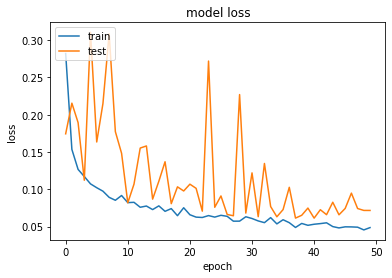

In [67]:
plot_history(vgg_history)

In [68]:
vgg_predictions = model.predict_proba(x_test)

In [69]:
vgg_df = pd.DataFrame({'id': ids, 'has_cactus': vgg_predictions.flatten()})

In [70]:
vgg_df.to_csv("vggsubmission.csv", index=False)